## Flu and Variant-Specific Booster Uptake

In this notebook, we the avaialability of flu clinics and compare it COVID variant-specific booster uptake. 

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
## HAWAII EXCLUDED DUE TO LACK OF BOOSTER DATA

state_list = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    # "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]

#### Cleaning and filtering COVID vaccine uptake dataset

In [50]:
## Import CDC COVID vaccine data

col_list_covid = ["Date", "Recip_State", "Booster_Doses", "Census2019"]
df_covid_raw = pd.read_csv(
    "../../data/cdc/COVID-19_Vaccinations_in_the_United_States_County.csv",
    usecols=col_list_covid,
)

In [51]:
## Rename columns

col_names_covid = {
    "Recip_State": "State",
    "Booster_Doses": "Booster",
    "Census2019": "Population",
}

df_covid_raw.rename(columns=col_names_covid, inplace=True)

In [52]:
## Filter to most recent data

df_covid_date = df_covid_raw.loc[df_covid_raw.Date == "09/28/2022"]

In [53]:
## Filter to 50 states

df_covid_state = df_covid_date.loc[df_covid_date.State.isin(state_list)]

In [54]:
## Group by states and sum raw booster and population values

df_covid_agg = df_covid_state.groupby("State", as_index=False).agg(
    {"Booster": "sum", "Population": "sum"}
)

In [55]:
## Calculate proportion of population with booster shot
### May want to consider using eligible population rather than total population

df_covid_agg["Boosted_Pct"] = df_covid_agg.Booster.div(
    df_covid_agg.Population
).multiply(100)

#### Cleaning and filtering flu locations dataset

In [56]:
## Import Vaccine.gov flu shot location data

col_list = [
    "provider_location_guid",
    "loc_admin_street1",
    "loc_admin_city",
    "loc_admin_state",
    "loc_admin_zip",
]
df_flu_raw = pd.read_csv(
    "../../data/cdc/Vaccines.gov__Flu_vaccinating_provider_locations.csv",
    usecols=col_list,
)

In [57]:
## Rename columns

col_names_flu = {
    "provider_location_guid": "ID",
    "loc_admin_street1": "Street",
    "loc_admin_city": "City",
    "loc_admin_state": "State",
    "loc_admin_zip": "Zip",
}

df_flu_raw.rename(columns=col_names_flu, inplace=True)

In [58]:
df_flu_raw["Zip"] = df_flu_raw["Zip"].str.split("-").str[0]

In [59]:
## Filter to 50 states

df_flu_state = df_flu_raw.loc[df_flu_raw.State.isin(state_list)]

In [60]:
## Drop duplicate values

df_flu_dedup = df_flu_state.drop_duplicates(subset=["ID"])

In [61]:
## Count number of flu shot locations

df_flu_agg = df_flu_dedup.groupby("State", as_index=False).agg({"ID": "count"})

#### Analyze flu and booster interaction

In [62]:
## Combine COVID vaccine dataset and flu shot locations dataset

df_final = pd.concat([df_covid_agg, df_flu_agg.ID], axis=1)

In [63]:
df_final.head()

,State,Booster,Population,Boosted_Pct,ID
0,AK,220577.0,731545.0,30.152212,60
1,AL,976959.0,4903185.0,19.924988,563
2,AR,713343.0,3017804.0,23.637817,256
3,AZ,2101781.0,7278717.0,28.875707,819
4,CA,16352202.0,39512223.0,41.385173,2615


[Text(0.5, 1.0, 'Relationship between number of flu clinics and booster uptake')]

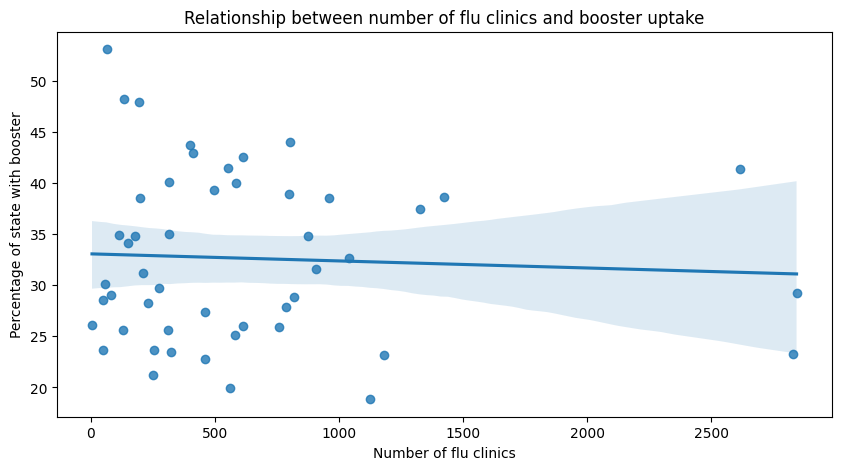

In [64]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.regplot(
    data=df_final,
    x="ID",
    y="Boosted_Pct",
    # y_partial=
)

ax.set(xlabel="Number of flu clinics", ylabel="Percentage of state with booster")
ax.set(title="Relationship between number of flu clinics and booster uptake")

#### Analyze potential confounding variables

In [65]:
## Import political election results

col_list_voting = [
    "year",
    "state_po",
    "candidatevotes",
    "totalvotes",
    "party_simplified",
]
df_voting_raw = pd.read_csv(
    "../../data/politics/1976-2020-president.csv",
    usecols=col_list_voting,
)

In [66]:
## Rename columns

col_names_voting = {
    "year": "Year",
    "state_po": "State",
    "candidatevotes": "Candidate Votes",
    "totalvotes": "Total Votes",
    "party_simplified": "Party",
}

df_voting_raw.rename(columns=col_names_voting, inplace=True)

In [67]:
df_voting_date = df_voting_raw.loc[df_voting_raw.Year == 2020]

In [68]:
party_list = ["REPUBLICAN"]

In [69]:
df_voting_party = df_voting_date.loc[df_voting_date.Party.isin(party_list)]

In [70]:
df_voting_state = df_voting_party.loc[
    df_voting_party.State.isin(state_list)
].reset_index()

In [71]:
df_voting_state["Vote_Pct"] = (
    df_voting_state["Candidate Votes"].div(df_voting_state["Total Votes"]).multiply(100)
)

In [72]:
df_final_votes = pd.concat([df_final, df_voting_state.Vote_Pct], axis=1)

In [73]:
df_final_votes.head()

,State,Booster,Population,Boosted_Pct,ID,Vote_Pct
0,AK,220577.0,731545.0,30.152212,60,62.031643
1,AL,976959.0,4903185.0,19.924988,563,52.833143
2,AR,713343.0,3017804.0,23.637817,256,49.055981
3,AZ,2101781.0,7278717.0,28.875707,819,62.395730
4,CA,16352202.0,39512223.0,41.385173,2615,34.320724


In [74]:
import statsmodels.formula.api as sm

result = sm.ols(formula="Boosted_Pct ~ ID + Vote_Pct", data=df_final_votes).fit()
print(result.params)

print(result.summary())

Intercept    56.928092
ID           -0.000959
Vote_Pct     -0.470411
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            Boosted_Pct   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     11.80
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           7.31e-05
Time:                        10:10:05   Log-Likelihood:                -162.40
No. Observations:                  49   AIC:                             330.8
Df Residuals:                      46   BIC:                             336.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------